In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
# Filter all warnings.
# spurious warnings.
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

# Import Python libraries

import numpy as np
import scipy as sp
import scipy.spatial.distance as spd
import scipy.cluster.hierarchy as sph
import sklearn as sk
import sklearn.metrics as skm
import sklearn.cluster as skc
import sklearn.decomposition as skd
import sklearn.mixture as skmix
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import random

import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.5)
plt.rcParams['font.size']=15

# 2017 Calgary Air B&B Data Analysis

The study was inspired by Tom Slee where they have studies surrounding the issue of empty homes and the effects on housing markets. So I wanted to analyze Calgary Air B&B hosts and their rental properties to identify the multi-property homeowners and if possible in the future expand to see the effects on the housing market.

In [4]:
originalcalgary = pd.DataFrame.from_csv('tomslee_airbnb_calgary_1558_2017-08-10.csv')

The original data had 18 columns. For simplicity, I removed the columns that had NaN values and columns that I did not use in the analysis: "bathrooms", "minstay", "survey_id", "location", "last_modified", "country", "city".

The resulting table is found below.

In [5]:
calgary = originalcalgary.drop(["bathrooms","minstay","survey_id","location","last_modified","country","city"], axis=1)
display(calgary.tail())

,host_id,room_type,borough,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,price,latitude,longitude
room_id,,,,,,,,,,,
4255248,9897546,Private room,WEST,LAKEVIEW,1,0.0,1,1,21,51.004444,-114.133817
20235217,16496313,Private room,CENTRE,CAMBRIAN HEIGHTS,0,0.0,2,1,22,51.079200,-114.085782
16084462,26167849,Private room,NORTH,HUNTINGTON HILLS,73,5.0,1,1,24,51.122176,-114.065547
19407973,964628,Private room,WEST,WEST SPRINGS,15,5.0,2,1,33,51.061953,-114.190224
15904682,102922818,Private room,EAST,ALBERT PARK/RADISSON HEIGHTS,46,5.0,2,1,29,51.042236,-113.999869


## Are there more hosts than rooms?

Initially, I wanted to see if there is a discrepancy to host and room count because I was thinking there should be one host to one rented out room. So I arranged the view by neighborhood to see how many rooms are rented out and overlayed the number of hosts. In the image below (Host count to room count), the neighborhood with the most rooms rented out is Beltline. However, there are over 368 rooms rented and only 306 hosts.

In [6]:
%%HTML
<div class='tableauPlaceholder' id='viz1550079345182' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ca&#47;CalgaryData_0&#47;hosttoroomcount&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='CalgaryData_0&#47;hosttoroomcount' /><param name='tabs' value='no' /><param name='toolbar' value='no' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ca&#47;CalgaryData_0&#47;hosttoroomcount&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1550079345182');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='1000px';vizElement.style.height='700px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

## Are there hosts' homes in different neighborhoods?

Diving in to individual neighborhoods, I wanted to see the distribution of homes/rooms owned by owners. Are they all in the same neighborhood or is there a host that owns a room in different sections of Calgary? Is there a rich host that monopolizes Calgary?

In below figure, the left map shows all the hosts and the room's location. The size shows the number of rooms the hosts owns and colored by host ID. The map on the right is the filtered map showing hosts that own over 5 rooms. As we can see, host 12365039 has many properties in the downtown core whereas host 9931937 has properties in numerous neighborhoods.

In [7]:
%%HTML
<div class='tableauPlaceholder' id='viz1550079037087' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ca&#47;CalgaryData_0&#47;Map&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='CalgaryData_0&#47;Map' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ca&#47;CalgaryData_0&#47;Map&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1550079037087');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='1000px';vizElement.style.height='827px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

## What if hosts are renting out single rooms?

Host 12365039 has many rooms in downtown vicinity so I was not sure if this was because the latitude and longitude drifted at time of data collection. As we know, Air B&B data does not provide accurate locations; so I thought the host was renting out multiple rooms out of one apartment. I proceeded to analyze the room types provided in the data set for the hosts that own over 5 rooms.

As we can see below, the total room types for all of the hosts shows over 108 properties are entire homes/apartments, 76 private rooms and 6 shared rooms. Therefore, there are some houses that rent out individual rooms making a host appear to have more properties. It's interesting to see that host 29122642 has a mix of private rooms and shared rooms. From this, I can only assume that they have two houses in located in Penbrooke Meadows and Shawnessy where they rent out individual rooms and shared space. 

There are links on the bar graph to the individual room ID's to see the actual details from the Air B&B webpage. Host 12365039 no longer lists their rooms as of 2019. Host 29122642 shared rooms means renting out a bed and sofa in the same shared space. They have a room ID for the sofa (18565209) and bed (16272900) under the staircase which was super cheap.

In [8]:
%%HTML
<div class='tableauPlaceholder' id='viz1550079259705' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ca&#47;CalgaryData_0&#47;HostRoomType&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='CalgaryData_0&#47;HostRoomType' /><param name='tabs' value='no' /><param name='toolbar' value='no' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ca&#47;CalgaryData_0&#47;HostRoomType&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1550079259705');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='1000px';vizElement.style.height='800px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

## What variables are useful to cluster the data?

I wanted to cluster the data to find patterns. At first I wanted to cluster the data in to neighborhoods but since we have 200 neighborhoods, there will be too many categories. Therefore, I tried clustering the data to boroughs which has 8 categories to make identifying patterns easier. 

The data was further cleaned by removing the rooms with zero reviews and zero overall satisfaction to prevent errors.

First, we explore the pairs scattered plot for numerical columns (price, reviews, overall satisfaction, accommodates, and bedrooms) to determine the relationships between each variables and identify patterns.

It appears plots with price and review as variables are skewed to the right. Accommodates and bathroom pairs have a linear relationship.

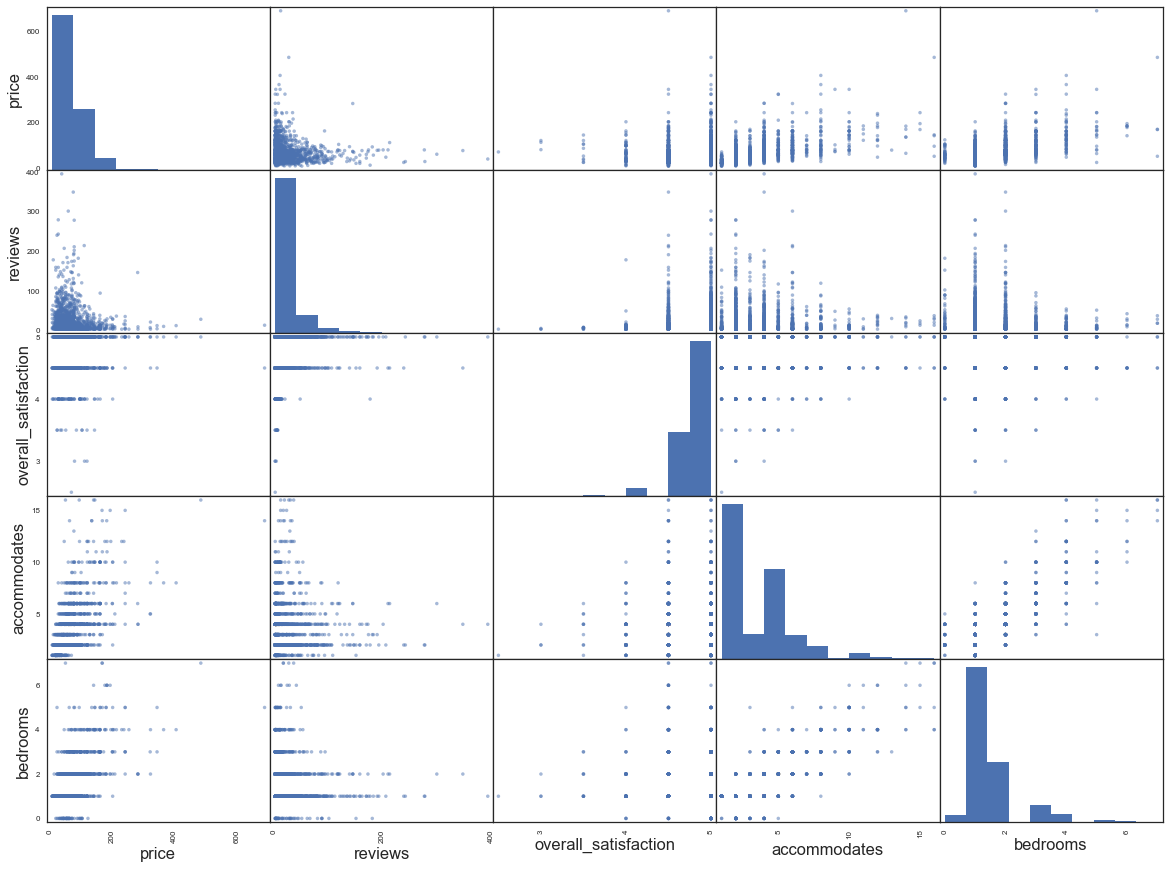

In [9]:
#number_col = ["survey_id", "host_id", "reviews", "overall_satisfaction", "accommodates","bedrooms","price"]

number_col = ["price","reviews", "overall_satisfaction", "accommodates","bedrooms"]
number_calgary = calgary[number_col].copy()
number_calgary = number_calgary[(number_calgary["reviews"]>0) & (number_calgary["overall_satisfaction"]>0)]
calgary = calgary[(calgary["reviews"]>0) & (calgary["overall_satisfaction"]>0)]
_ = pd.plotting.scatter_matrix(number_calgary, figsize=(20,15))

In [10]:
# Function to create a list of unique pairing of the input variables

def all_pairs(source):
    result = []
    for p1 in range(len(source)):
        for p2 in range(p1+1, len(source)):
            result.append([source[p1],source[p2]])
    return result

I tested using Euclidean and Chebyshev distance measure to calculate the distance matrix for the following pairs. Additionally testing with single, average and complete linkage. The least expensive on computational power was Euclidean distance measure and average linkage. The dendogram and clustering was found to be similar between Euclidean and Chebyshev distance measures. Therefore, I proceeded with below Hierchical clustering method based on Euclidean distanc and average linkage.

In [11]:
# Produce a list of unique pairing of the numerical variables

pairs = all_pairs(number_col)
pairs

[['price', 'reviews'],
 ['price', 'overall_satisfaction'],
 ['price', 'accommodates'],
 ['price', 'bedrooms'],
 ['reviews', 'overall_satisfaction'],
 ['reviews', 'accommodates'],
 ['reviews', 'bedrooms'],
 ['overall_satisfaction', 'accommodates'],
 ['overall_satisfaction', 'bedrooms'],
 ['accommodates', 'bedrooms']]

In [12]:
# Function to apply hierchical clustering, produce dendograms and clustered scatter plots

def hierchical_clustering_method(pair_var):
    df_xy = calgary[pair_var]

    # Computing distance measures
    dist_xy = spd.squareform(spd.pdist(df_xy, metric = 'euclidean'))
    # metric = euclidean/chebyshev
    
    # Perform hierarchical clustering and plot the dendrogram.
    # Computing linkage distance 
    Z_xy = sph.linkage(dist_xy, method='average') 
    
    # Plotting dendogram
    plt.subplots(figsize=(12,8))
    _ = sph.dendrogram(Z_xy)

    plt.xlabel('Data Points')
    plt.ylabel('Distance')
    plt.suptitle('Dendrogram: ' + str(pair_var), 
                 fontweight='bold', fontsize=20)
    plt.show()    
    
    return dist_xy, Z_xy

def hierchical_cut(dist,pair_var, Z_xy):
    # Cluster labels
    cluster_labels = sph.fcluster(Z_xy, dist, criterion='distance')
    # criterion = maxclust
    
    calgary['cluster_label'] = cluster_labels

    # Cluster image
    sns.lmplot(x=pair_var[0],y=pair_var[1], hue='cluster_label',
           fit_reg=False, data=calgary, size=5, aspect=1.3, scatter_kws={"s": 100})
    ax = plt.gca()
    ax.set_title("Clustered scatter plot for " + str(pair_var))

    plt.show()

D:\cekwo\Anaconda\lib\site-packages\ipykernel_launcher.py:12: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  if sys.path[0] == '':


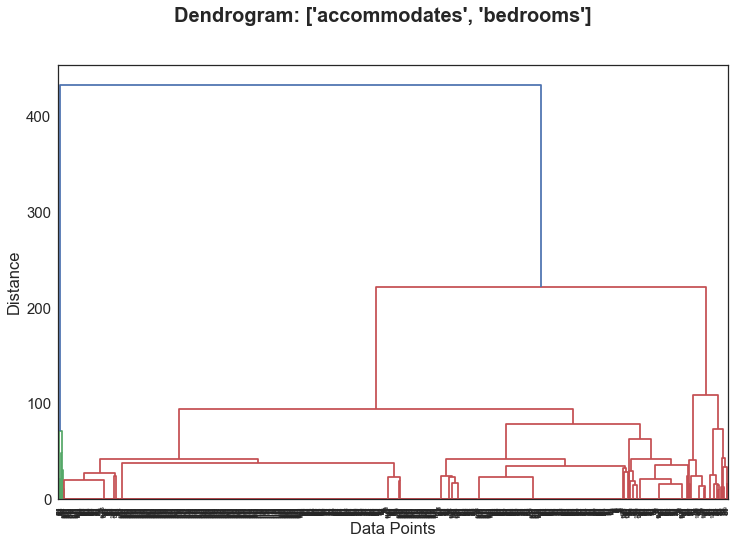

In [13]:
# Variables Accommodates and bedrooms

pair_var = pairs[9]
dist_xy, Z_xy = hierchical_clustering_method(pair_var)


The above hierchical graph shows the dendrogram of the pair variables: accommodates and bedrooms. The tree was cut at 80 to produce meaningful clusters in below scatter plots. When the tree was cut at larger distances, the resulting number of clusters were less than 7. At lower distances, the clustering method provided too many clusters.

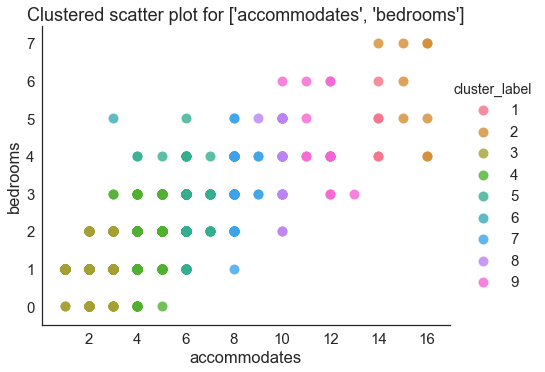

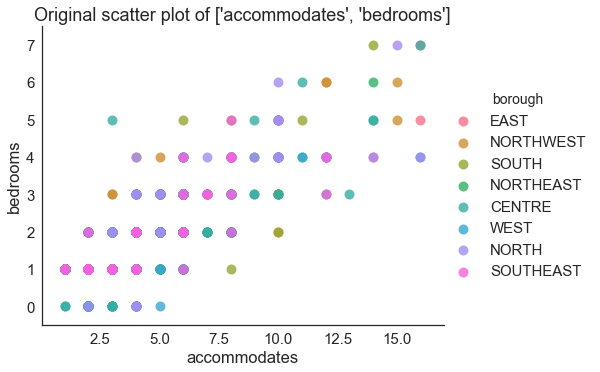

In [14]:
# Trimming hierchical tree to determine number of clusters

cut_dist = 50

hierchical_cut(cut_dist, pair_var, Z_xy)

sns.lmplot(x=pair_var[0], y=pair_var[1], hue='borough',
          fit_reg=False, data=calgary, size=5, aspect=1.3, scatter_kws={"s": 100})

ax = plt.gca()
ax.set_title('Original scatter plot of ' + str(pair_var))

plt.show()

D:\cekwo\Anaconda\lib\site-packages\ipykernel_launcher.py:12: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  if sys.path[0] == '':


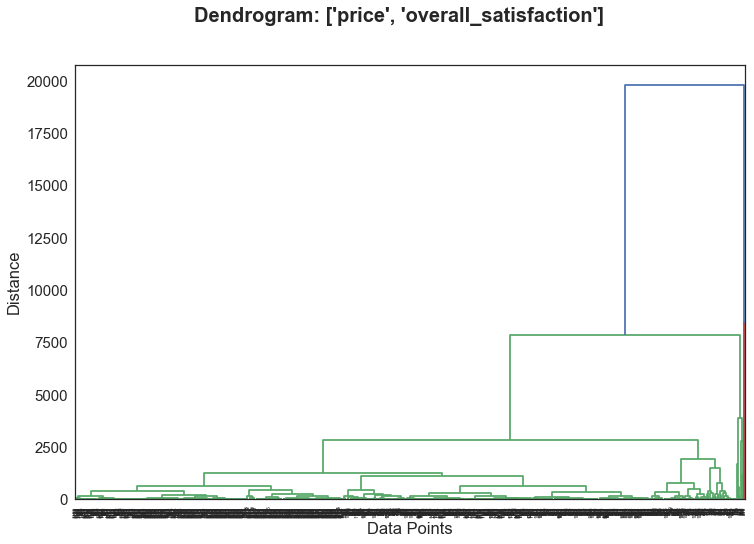

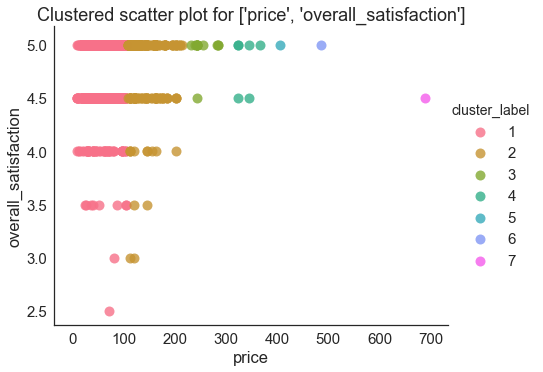

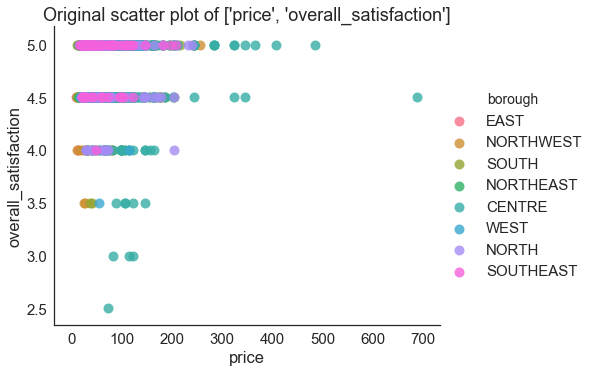

In [15]:
cut_dist = 2500
pair_var = pairs[1]
dist_xy, Z_xy = hierchical_clustering_method(pair_var)

hierchical_cut(cut_dist, pair_var, Z_xy)

sns.lmplot(x=pair_var[0], y=pair_var[1], hue='borough',
          fit_reg=False, data=calgary, size=5, aspect=1.3, scatter_kws={"s": 100})

ax = plt.gca()
ax.set_title('Original scatter plot of ' + str(pair_var))

plt.show()

## Somewhat best variables to cluster the data?

Even though the variables bedrooms, accommodates and price, overall satisfaction mis-clusters some of the data points. The overall scatter plot is similar to the original data. Visually, the clustered patterns shares similarities to the original data.

### K-Means

I used the elbow method to determine the appropriate numbers of clusters using the Euclidean distance measure. The numbers of clusters were then used in the K Means clustering method. 

The K Means clustering centroids were off from the data. I believe more analysis will be required to figure out a better calculation for these distances.

In [16]:
def elbow_method(pair_var):
    df_xy = calgary[pair_var]
    K = range(1,41)  # Apply kmeans 1 to 40
    kmeans_models = [skc.KMeans(k).fit(df_xy) for k in K]
    centroids = [m.cluster_centers_ for m in kmeans_models]
    D_k = [spd.cdist(df_xy, cent, 'euclidean') for cent in centroids]
    cIdx = [np.argmin(D, axis=1) for D in D_k]
    dist = [np.min(D, axis=1) for D in D_k]
    avgWithinSS = [sum(d)/df_xy.shape[0] for d in dist]

    # plot elbow curve
    plt.plot(K, avgWithinSS, 'b*-')
    plt.xlabel('Number of clusters');
    plt.ylabel('Average within-cluster sum of squares');
    plt.title('Elbow method for K-Means clustering');
    
    fname = 'elbow ' + str(pair_var)
    plt.savefig(fname)
    plt.show()

def kmeans_clustered(n_clusters, pair_var):
    df_xy = calgary[pair_var]
    kmeans_model = skc.KMeans(n_clusters= n_clusters)
    kmeans_model.fit(df_xy)
    centroids = kmeans_model.cluster_centers_
    
    df_xy['cluster_labels_kmeans'] = kmeans_model.labels_
    f = sns.lmplot(x=pair_var[0], y=pair_var[1], data=df_xy, hue='cluster_labels_kmeans',
                   fit_reg=False, size=5, aspect=1.3)
    f.ax.scatter(centroids[:,0], centroids[:,1], marker='+', s=100,
                 linewidths=2, color='k');
    plt.title('K-Means centroids for ' + str(pair_var) + ' (k= ' + str(n_clusters) +')', fontsize=15)
    
    fname = 'kmeans_cluster ' + str(pair_var)
    plt.savefig(fname)
    plt.show()

The "Elbow method for K-Means clustering" was intially plotted up to 10 clusters; however, the plot did not allow an easily identifiable elbow to determine the number of clusters. Thus, I increased the plot to 40 which was obtained from the rough estimate for number of clusters ($\sqrt{n/2}=38$); producing a better imagery of how increasing the number of clusters after 7 will not make much difference to minimizing the distance between clusters.

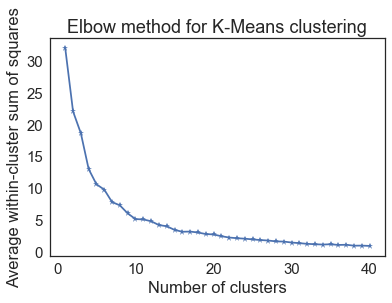

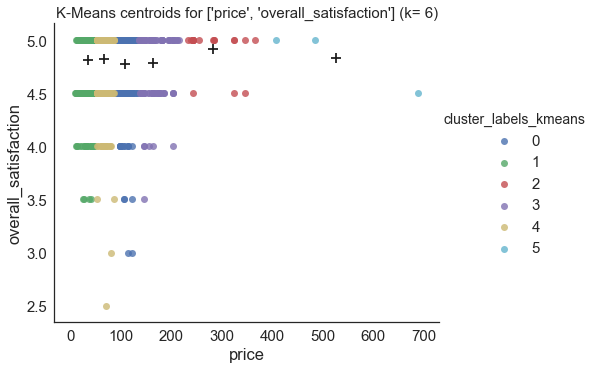

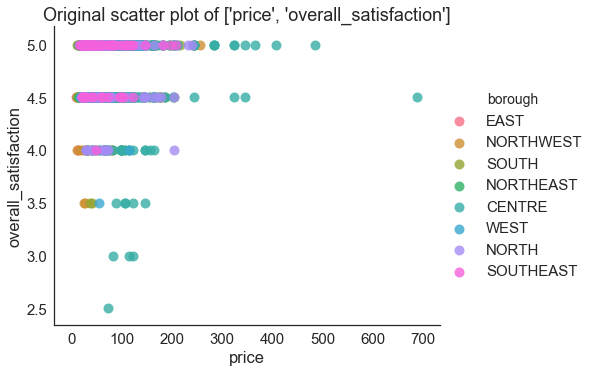

In [17]:
n_clusters = 6
pair_var = pairs[1]

elbow_method(pair_var)
kmeans_clustered(n_clusters, pair_var)


sns.lmplot(x=pair_var[0], y=pair_var[1], hue='borough',
          fit_reg=False, data=calgary, size=5, aspect=1.3,scatter_kws={"s": 100})
ax = plt.gca()
ax.set_title('Original scatter plot of ' + str(pair_var))
plt.show()

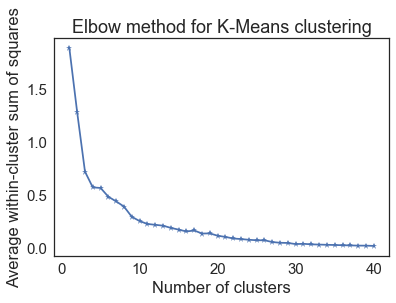

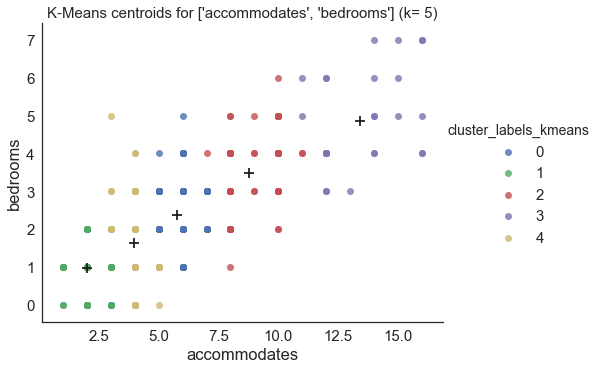

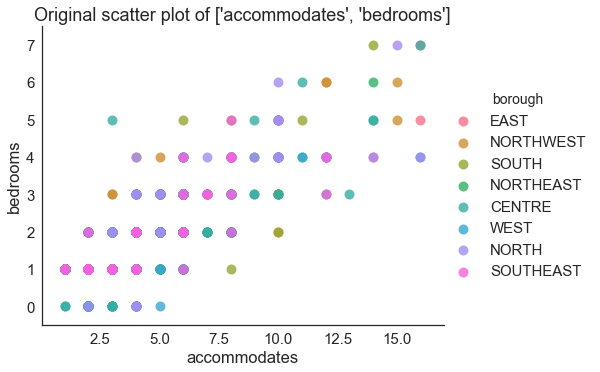

In [18]:
n_clusters = 5
pair_var = pairs[9]

elbow_method(pair_var)
kmeans_clustered(n_clusters, pair_var)


sns.lmplot(x=pair_var[0], y=pair_var[1], hue='borough',
          fit_reg=False, data=calgary, size=5, aspect=1.3, scatter_kws={"s": 100})
ax = plt.gca()
ax.set_title('Original scatter plot of ' + str(pair_var))
plt.show()

### K-Means Clustering?

K-Means clustering appears to identify more variability in the data based on variable pairings (accommodates and bedrooms), (price, overall satisfaction). K-Means does not particularly group clusterings in to boroughs accurately compared to Hierchical method.

## How well can we predict boroughs with classification methods?

I used both K-Nearest Neighbors and Naive Bayes classification methods to predict the borough focusing on specific variables.

### K-Nearest Neighbors - KNN Classification Method

The variables obtained from the clustering method were used to apply the K-Nearest Neighbors classifier.  From the confusion matrix, many of the correct labels were identified as "Centre", where over 300 labels were incorrectly mis-labeled as "Centre". 

Testing the accuracy, precision (percent of items returned that are true positives), F1 score (weighted average of precision and recall) and recall (percent of the positive items returned) have showed that having all four variables gave the highest precision and F1 score. If we only classified based on price and overall Satisfaction, the recall, precision and F1 score drops. Similar results were found if we only classifed based on bedrooms and accommodates. 

In [19]:
calgary.head()
knn_df = calgary[['price', 'overall_satisfaction']]

In [20]:
# Import library - from sklearn.model_selection import train_test_split

random.seed(5)
f_train, f_test, l_train, l_test = train_test_split(knn_df,calgary['borough'], test_size=0.4, random_state=random.randint(0,1000))


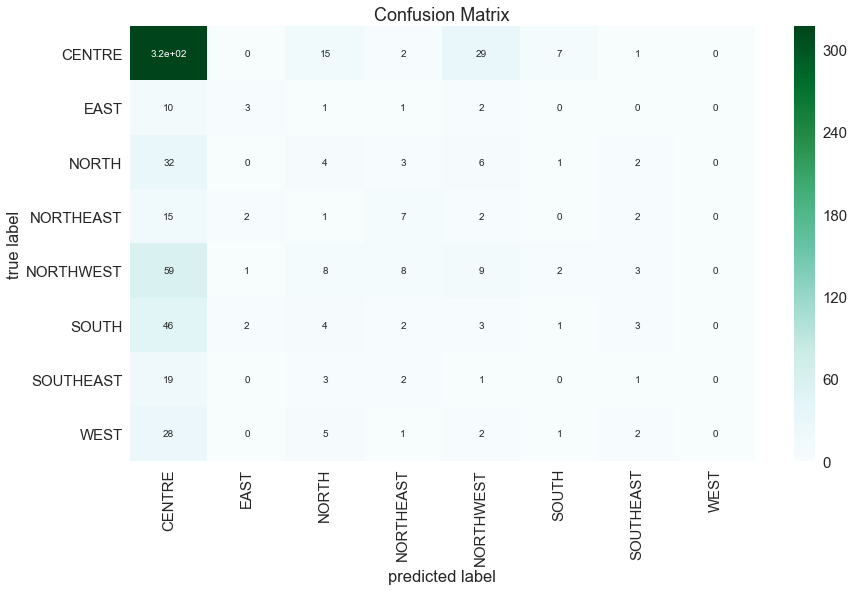

In [21]:
# Import library - from sklearn.neighbors import KNeighborsClassifier

n=8
calgary_knn = KNeighborsClassifier(n_neighbors=n)
calgary_knn.fit(f_train, l_train) 
calgary_pred = calgary_knn.predict(knn_df)

calgary_knn_pred = calgary_knn.predict(f_test)

calgary_knn_cfmat = skm.confusion_matrix(
    y_true=l_test,
    y_pred=calgary_knn_pred,)

plt.subplots(figsize = (14,8))
sns.heatmap(calgary_knn_cfmat, 
            xticklabels=calgary_knn.classes_,
            yticklabels=calgary_knn.classes_,
            annot=True, cmap = 'BuGn')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.title('Confusion Matrix')
#plt.savefig('Confusion Matrix')
plt.show()

In [22]:
# Accuracy
print("Accuracy: ",skm.accuracy_score(y_true=l_test,
                   y_pred=calgary_knn_pred))

# Precision
print("Precision: ",skm.precision_score(y_true = l_test,
                    y_pred = calgary_knn_pred,
                    average = 'weighted'))

# F1 Score
print("F1 Score: ",skm.f1_score(y_true=l_test,
             y_pred=calgary_knn_pred,
             average='weighted'))

# Recall
print("Recall: ",skm.recall_score(y_true=l_test,
                 y_pred=calgary_knn_pred,
                 average='weighted'))

Accuracy:  0.5022026431718062
Precision:  0.38824309515259864
F1 Score:  0.42910517362769496
Recall:  0.5022026431718062


D:\cekwo\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\cekwo\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Naive Bayes

The application of Naive Bayes was used to compare the methods and accuracy of the classification. However, I used all numerical variables: price, reviews, overall satisfaction, accommodates, and bedrooms - in hopes of producing better values for accuracy, precision, recall and F1 scores. The produced confusion matrix was found to be similar to the KNN method even though all of the variables were applied in the matrix. Reducing the number of variables to match the KNN method resulted in decreasing the parameters: accuracy, precision, F1 score and recall. 

Thus, both classification methods were found to only be able to predict the boroughs accurately 47-49% of the time.

In [23]:
# Import - from sklearn.naive_bayes import GaussianNB

random.seed(15)
f_train, f_test, l_train, l_test = train_test_split(calgary[number_col],calgary['borough'], test_size=0.4, random_state=random.randint(0,1000))

calgary_gnb = GaussianNB().fit(calgary[number_col], calgary['borough'])
calgary_gnb_predictions = calgary_gnb.predict(calgary[number_col])

calgary_test = GaussianNB().fit(f_train,l_train)
calgary_gnb_pred_test = calgary_gnb.predict(f_test)

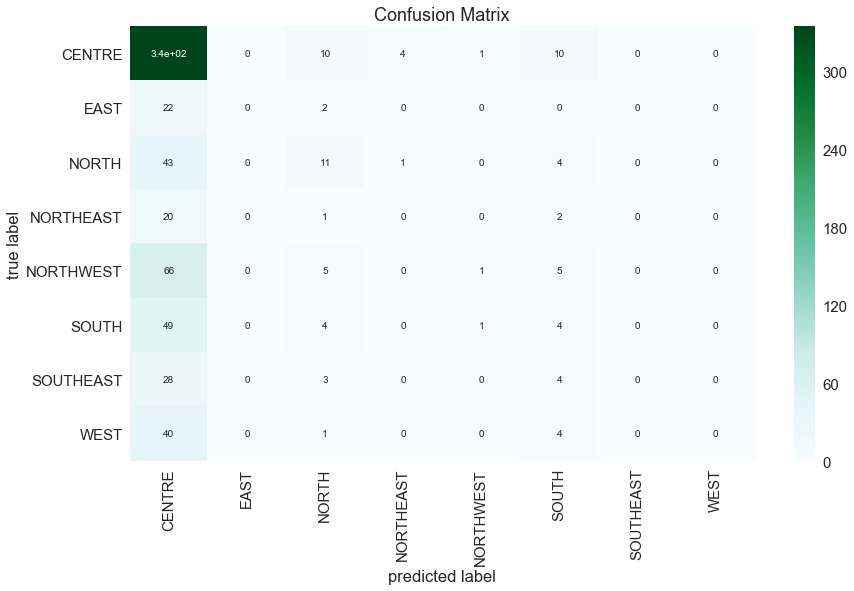

In [24]:
calgary_gnb_cfmat = skm.confusion_matrix(
    y_true=l_test,
    y_pred=calgary_gnb_pred_test,)

plt.subplots(figsize = (14,8))
sns.heatmap(calgary_gnb_cfmat, 
            xticklabels=calgary_gnb.classes_,
            yticklabels=calgary_gnb.classes_,
            annot=True, cmap = "BuGn")
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.title('Confusion Matrix')
plt.savefig('Naive Confusion Matrix')
plt.show()

In [25]:
# Accuracy
print("Accuracy: ",skm.accuracy_score(y_true=l_test,
                   y_pred=calgary_gnb_pred_test))

# Precision
print("Precision: ",skm.precision_score(y_true = l_test,
                    y_pred = calgary_gnb_pred_test,
                    average = 'weighted'))
# F1 Score
print("F1 Score: ",skm.f1_score(y_true=l_test,
             y_pred=calgary_gnb_pred_test,
             average='weighted'))

# Recall
print("Recall: ",skm.recall_score(y_true=l_test,
                 y_pred=calgary_gnb_pred_test,
                 average='weighted'))

Accuracy:  0.5154185022026432
Precision:  0.36745596216961857
F1 Score:  0.3979618563169759
Recall:  0.5154185022026432


D:\cekwo\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\cekwo\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


I would say the classification by K-Nearest Neighbors (KNN) appear to provide more accurate labelling than Naive Bayes classification. However, the classification is mainly predicts "Centre" labels. Classifying with variables: Latitude and Longitude, accurately predicts the boroughs giving over 90% accuracy. 

Below is the confusion matrix if we base the classification off geographic data. I think more analysis will need to be done to include more data for different boroughs or use classification to predict neighborhoods.

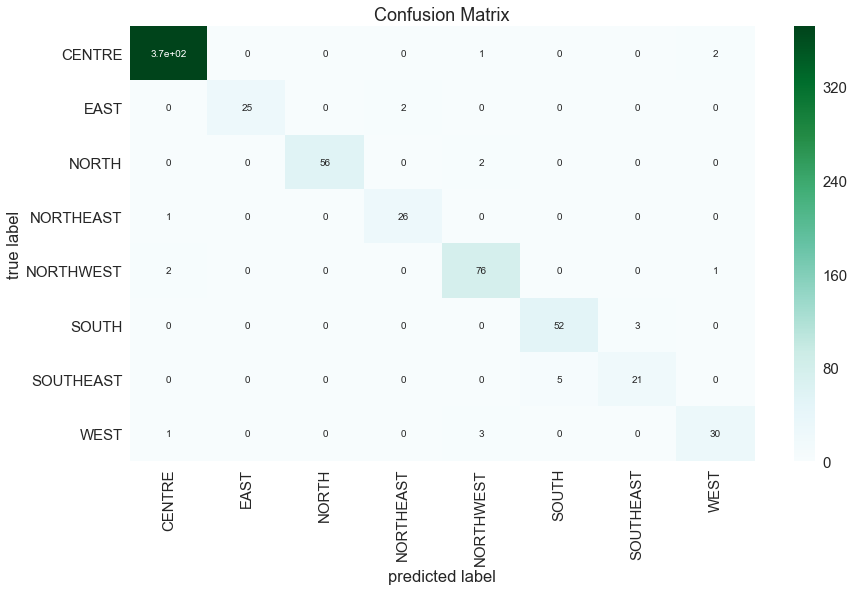

Accuracy:  0.9662261380323054
Precision:  0.9664260037738693
F1 Score:  0.9661071490147242
Recall:  0.9662261380323054


In [26]:
# Plotting classification with longitude and latitude variables

latlong = calgary[['latitude','longitude']]

random.seed(50)
f_train, f_test, l_train, l_test = train_test_split(latlong,calgary['borough'], test_size=0.4, random_state=random.randint(0,1000))

calgary_gnb = GaussianNB().fit(latlong, calgary['borough'])
calgary_gnb_predictions = calgary_gnb.predict(latlong)

calgary_test = GaussianNB().fit(f_train,l_train)
calgary_gnb_pred_test = calgary_gnb.predict(f_test)

calgary_gnb_cfmat = skm.confusion_matrix(
    y_true=l_test,
    y_pred=calgary_gnb_pred_test,)

plt.subplots(figsize = (14,8))
sns.heatmap(calgary_gnb_cfmat, 
            xticklabels=calgary_gnb.classes_,
            yticklabels=calgary_gnb.classes_,
            annot=True, cmap = "BuGn")
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.title('Confusion Matrix')
plt.savefig('Naive Confusion Matrix')
plt.show()

# Accuracy
print("Accuracy: ",skm.accuracy_score(y_true=l_test,
                   y_pred=calgary_gnb_pred_test))

# Precision
print("Precision: ",skm.precision_score(y_true = l_test,
                    y_pred = calgary_gnb_pred_test,
                    average = 'weighted'))
# F1 Score
print("F1 Score: ",skm.f1_score(y_true=l_test,
             y_pred=calgary_gnb_pred_test,
             average='weighted'))

# Recall
print("Recall: ",skm.recall_score(y_true=l_test,
                 y_pred=calgary_gnb_pred_test,
                 average='weighted'))

# Thank you for your attention

### Issues

I had issues with plotting the map with the hosts filtered for a cleaner view because the chloropleth portion will also disappear. The only solution I found was to have both maps displayed and filter the full map based on the selection from the simplified map.

Additonal testing will need to accurately identify the best variables for clustering. I think K-Means was the better clustering method but I would like to try other methods for comparison.

Latitude and longitude gave almost 100% classification which is obviously true as these are location markers. I will need to calculate probabilities for categorical data to include more variables for testing.

I should remove rooms with zero reviews and zero overall satisfaction and would like to further test if the cleaned data will provide more accurate results.

# References

1. Willet, Wesley. DATA 605 Class - Codes and all.
2. Slee, Tom. Air B&B Data. Accessed Jan 3, Online http://tomslee.net/airbnb-data-collection-get-the-data
3. Tim Cruz. DATA 605 Class - Code
